In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import webcolors
from PIL import Image, ImageDraw

import networkx as nx

from minimal.imaging import blit_rooms, draw_sep_nask_wireframe
from minimal.layout import InputGraph, NodeType, NODE_COLOR
from minimal.gen import PlanMasks

from minimal.common import conv_mask
from minimal.rooms import calc_min_area, RectGraph, scale_room_masks
from minimal.walls import create_sep_mask, scale_sep_mask, extract_face_walls
from minimal.join_solving import select_rooms_to_join
from minimal.doors import create_doors, create_cut_wall_mask

%matplotlib inline

In [3]:
cmapr = ListedColormap(['white', *plt.get_cmap('tab10').colors])
cmapw = ListedColormap(['white', 'black', *plt.get_cmap('tab10').colors])

CPU times: user 1.12 ms, sys: 644 µs, total: 1.77 ms
Wall time: 1.18 ms


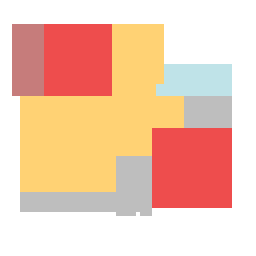

<PlanMasks 132269094291392>

In [4]:
%%time
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_01.pth"))
pm

In [5]:
input_graph = pm.graph
scale = (3, 3)

In [6]:
segmentation_masks = [pm.masks[i] for i in range(pm.masks.shape[0]) if NodeType.is_room(pm.graph.nodes[i])]
node_types = [pm.graph.nodes[i] for i in range(pm.masks.shape[0]) if NodeType.is_room(pm.graph.nodes[i])]
R = len(segmentation_masks)
print(R)

9


In [8]:
min_area_units = calc_min_area(scale)

rect_graphs = []
for i in range(R):
    room_type = node_types[i]
    room_sgm_mask = segmentation_masks[i]

    graph = RectGraph(room_type, i, room_sgm_mask)

    # Remove short rectangles
    #
    # TODO: maybe keep rectangles with degree >= 2 as they
    #       will prove to be a "pathway" between multiple
    #       (potentially) disconnected rooms
    # TODO: store the removed rects ("bad" rects) to maybe
    #       salvage them later on
    graph.threshold_rectangles(min_area_units)

    # Keep the largest connected component (by total area)
    # 
    # TODO: store the removed rects ("bad" rects) to maybe
    #       salvage them later on
    graph.discard_small_components()

    rect_graphs.append(graph)

rect_graphs.sort(key=lambda g: g.total_area())

In [11]:
room_masks = [] # room_mask(r): 1 = yes r / 0 = no r
for graph in rect_graphs:
    room_masks.append(graph.to_mask())

sep_mask = create_sep_mask(room_masks)

room_masks = scale_room_masks(room_masks, scale)
sep_mask = scale_sep_mask(sep_mask, *scale)

print(room_masks[0].shape)
print(sep_mask.shape)

torch.Size([192, 192])
torch.Size([192, 192])


In [15]:
face_walls = extract_face_walls(sep_mask)

rooms_to_join = select_rooms_to_join(rect_graphs, pm.graph)
doors = create_doors(R, rooms_to_join, room_masks, face_walls)

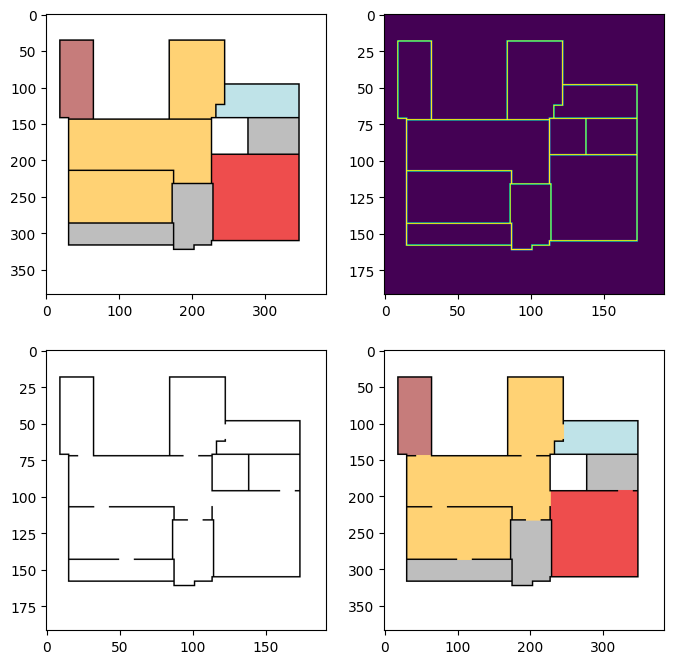

In [16]:
walls = create_cut_wall_mask(sep_mask, doors)

plt.figure(figsize=(8,8))

plt.subplot(221)
plt.imshow(blit_rooms(rect_graphs, sep_mask, out_size=384))

plt.subplot(222)
plt.imshow((sep_mask > 0).byte())

plt.subplot(223)
plt.imshow(1 - walls, cmap="gray")

plt.subplot(224)
plt.imshow(blit_rooms(rect_graphs, walls, out_size=384))